In [115]:
import torch
from einops import pack

from tqdm import tqdm, trange

import torch.nn as nn

import json

import matplotlib.pyplot as plt

In [106]:
X_train, y_train = torch.load("clean_dataset/X_train.pt"), torch.load("clean_dataset/y_train.pt")

In [107]:
X_packed, _ = pack([X_train, y_train], "b *")

In [108]:
diseases = int(torch.max(X_packed[:, -1]).item()) + 1
disease_symptom_freq = torch.zeros(diseases, len(X_packed[0]) - 1).int()

In [109]:
disease_symptom_freq.shape

torch.Size([49, 894])

In [110]:
disease_symptom_mean = torch.zeros_like(disease_symptom_freq)

In [112]:
disease_freq = torch.zeros(diseases)

In [114]:
for i in trange(0, len(X_packed)):
  dis = int(X_packed[i, -1].item())
  disease_symptom_freq[dis] += (X_packed[i, :-1] != 0)
  disease_symptom_mean[dis] += (X_packed[i, :-1]).int()
  disease_freq[dis] += 1

100%|██████████| 1025602/1025602 [01:13<00:00, 14003.88it/s]


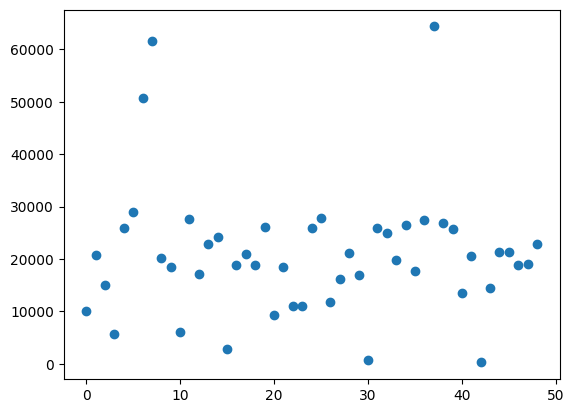

In [118]:
plt.plot(range(len(disease_freq)), disease_freq, 'o')

In [127]:
class ResBlock(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.in_features = in_features
    self.net = nn.Sequential(
      nn.Linear(in_features, in_features),
      nn.BatchNorm1d(in_features),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(in_features, in_features),
      nn.BatchNorm1d(in_features),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(in_features, in_features),
      nn.BatchNorm1d(in_features),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(in_features, in_features),
      nn.BatchNorm1d(in_features),
      nn.ReLU(),
      nn.Dropout(0.3)
    )
  
  def forward(self, x):
    return x + self.net(x)

In [128]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [129]:
with open("clean_dataset/diseases.json") as file:
  diseases = json.loads(file.read())

In [130]:
with open("clean_dataset/evidences.json") as file:
  evidences = json.loads(file.read())

In [131]:
class_count = len(diseases)
feature_count = len(evidences)

In [132]:
model = nn.Sequential(
  nn.Linear(feature_count, feature_count // 2),
  nn.ReLU(),
  ResBlock(feature_count // 2),
  nn.Linear(feature_count // 2, feature_count // 4),
  nn.ReLU(),
  ResBlock(feature_count // 4),
  nn.Linear(feature_count // 4, feature_count // 8),
  nn.ReLU(),
  ResBlock(feature_count // 8),
  nn.Linear(feature_count // 8, class_count),
  nn.ReLU(),
  ResBlock(class_count),
  nn.Softmax()
  )


In [133]:
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [134]:
model.eval()

Sequential(
  (0): Linear(in_features=894, out_features=447, bias=True)
  (1): ReLU()
  (2): ResBlock(
    (net): Sequential(
      (0): Linear(in_features=447, out_features=447, bias=True)
      (1): BatchNorm1d(447, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=447, out_features=447, bias=True)
      (5): BatchNorm1d(447, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.3, inplace=False)
      (8): Linear(in_features=447, out_features=447, bias=True)
      (9): BatchNorm1d(447, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.3, inplace=False)
      (12): Linear(in_features=447, out_features=447, bias=True)
      (13): BatchNorm1d(447, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): ReLU()
      (15): Dropout(p=0.3, inplace=False)
    )
  

In [146]:
def disease_int(index):
  for key, value in diseases.items():
    if str(value) == str(index):
      return key

In [147]:
for i in range(0, class_count):
  input = torch.zeros(1, len(X_packed[0]) - 1)
  top_10 = torch.topk(disease_symptom_freq[i], 10).indices
  for sy in top_10:
    input[0, sy] = 1
  output = torch.argmax(model(input))

  if output.item() == i:
    print(f'Disease {i}: {disease_int(i)}')
    for sy in top_10:
      for key, value in evidences.items():
        if int(value["index"]) == sy:
          print(value["short"])

c:\Users\Claudiu\miniconda3\envs\lv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Disease 0: Spontaneous pneumothorax
Pain doesn't radiate
Pain precision (popup)
Pain related to this consult
How fast did the pain appear? (popup)
Pain intensity scale (popup)
Pain increases when you breathe in deeply
Had spontaneous pneumothorax
Smoking cigarettes
Knife stroke pain
Right breast pain
Disease 2: Boerhaave
Pain intensity scale (popup)
Pain precision (popup)
Pain related to this consult
How fast did the pain appear? (popup)
Vomited / made attempts to vomit
Nauseous / feel like vomiting
Epigastric pain
Sickening pain
Haunting pain
Pain radiates to thoracic spine
Disease 3: Spontaneous rib fracture
Pain related to this consult
Pain intensity scale (popup)
Pain precision (popup)
How fast did the pain appear? (popup)
Pain that increases with movement
Pain increases when you breathe in deeply
Intense coughing fits
Treated for osteoporosis
Knife stroke pain
Heartbreaking pain
Disease 4: GERD
Pain intensity scale (popup)
Pain precision (popup)
Pain related to this consult
How fa